# Deep Neural Networks: Visualizations and Explanations (Solutions)

This notebook provides visualizations and explanations for key concepts related to training deep neural networks, complementing the lecture slides. We will explore:

1.  **Adaptive Learning Rates:** Visualizing how different optimization algorithms navigate a loss landscape.
2.  **Error Landscapes:** Understanding saddle points and their impact on optimization.
3.  **Debugging:** Interpreting loss and accuracy curves during training.
4.  **Performance Metrics:** Evaluating model performance, especially on imbalanced datasets.

**Solutions Version:**
- All TODO tasks have been implemented
- All questions have been answered with detailed explanations
- Run all cells to see the visualizations and results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Adaptive Learning Rates and Optimization Algorithms

Gradient descent algorithms are used to minimize the loss function by iteratively updating the model parameters. Different algorithms adapt the learning rate or use momentum to navigate the loss landscape more effectively. Let's visualize the paths taken by different optimizers on a simple quadratic loss surface.

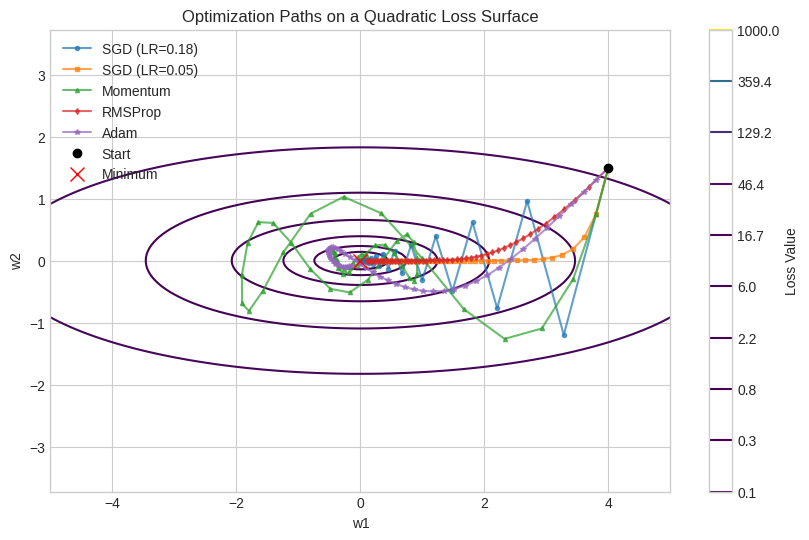

In [2]:
# Define a simple quadratic loss function (representing a simple error landscape)
def loss_function(w1, w2):
    return 0.5 * (w1**2 + 10 * w2**2) # Elliptical bowl shape

# Define gradients for the loss function
def gradients(w1, w2):
    return np.array([w1, 10 * w2])

# --- Optimization Algorithms Implementation ---

# Standard SGD
def sgd(w_init, n_iterations, learning_rate):
    w_path = [w_init]
    w = w_init.copy()
    for _ in range(n_iterations):
        grad = gradients(w[0], w[1])
        w = w - learning_rate * grad
        w_path.append(w.copy())
    return np.array(w_path)

# SOLUTION: Implement SGD with Momentum
def sgd_momentum(w_init, n_iterations, learning_rate, momentum=0.9):
    w_path = [w_init]
    w = w_init.copy()
    v = np.zeros_like(w)
    for _ in range(n_iterations):
        # 1. Calculate gradient
        grad = gradients(w[0], w[1])
        # 2. Update velocity v using momentum formula
        v = momentum * v + learning_rate * grad
        # 3. Update weights w
        w = w - v
        # 4. Append to w_path
        w_path.append(w.copy())
    return np.array(w_path)

# RMSProp
def rmsprop(w_init, n_iterations, learning_rate, decay_rate=0.9, epsilon=1e-8):
    w_path = [w_init]
    w = w_init.copy()
    r = np.zeros_like(w) # Accumulated squared gradient
    for _ in range(n_iterations):
        grad = gradients(w[0], w[1])
        r = decay_rate * r + (1 - decay_rate) * grad**2
        update = (learning_rate / (np.sqrt(r) + epsilon)) * grad
        w = w - update
        w_path.append(w.copy())
    return np.array(w_path)

# Adam
def adam(w_init, n_iterations, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
    w_path = [w_init]
    w = w_init.copy()
    s = np.zeros_like(w) # First moment estimate
    r = np.zeros_like(w) # Second moment estimate
    t = 0
    for _ in range(n_iterations):
        t += 1
        grad = gradients(w[0], w[1])
        s = beta1 * s + (1 - beta1) * grad
        r = beta2 * r + (1 - beta2) * grad**2
        s_hat = s / (1 - beta1**t)
        r_hat = r / (1 - beta2**t)
        update = (learning_rate / (np.sqrt(r_hat) + epsilon)) * s_hat
        w = w - update
        w_path.append(w.copy())
    return np.array(w_path)

# --- Visualization ---

# Initial point
w_init = np.array([4.0, 1.5])
n_iterations = 50

# Run optimizers
path_sgd_fast = sgd(w_init, n_iterations, learning_rate=0.18) # Can oscillate
path_sgd_slow = sgd(w_init, n_iterations, learning_rate=0.05) # Slow convergence
path_momentum = sgd_momentum(w_init, n_iterations, learning_rate=0.05, momentum=0.9)
path_rmsprop = rmsprop(w_init, n_iterations, learning_rate=0.1)
path_adam = adam(w_init, n_iterations, learning_rate=0.2)

# Create contour plot
w1_range = np.linspace(-5, 5, 100)
w2_range = np.linspace(-2, 2, 100)
W1, W2 = np.meshgrid(w1_range, w2_range)
Z = loss_function(W1, W2)

plt.figure(figsize=(10, 6))
contour = plt.contour(W1, W2, Z, levels=np.logspace(-1, 3, 10), cmap='viridis')
plt.colorbar(contour, label='Loss Value')

# Plot paths
plt.plot(path_sgd_fast[:, 0], path_sgd_fast[:, 1], 'o-', label='SGD (LR=0.18)', markersize=3, alpha=0.7)
plt.plot(path_sgd_slow[:, 0], path_sgd_slow[:, 1], 's-', label='SGD (LR=0.05)', markersize=3, alpha=0.7)
plt.plot(path_momentum[:, 0], path_momentum[:, 1], '^-', label='Momentum', markersize=3, alpha=0.7)
plt.plot(path_rmsprop[:, 0], path_rmsprop[:, 1], 'd-', label='RMSProp', markersize=3, alpha=0.7)
plt.plot(path_adam[:, 0], path_adam[:, 1], '*-', label='Adam', markersize=4, alpha=0.7)

plt.plot(w_init[0], w_init[1], 'ko', label='Start') # Start point
plt.plot(0, 0, 'rx', label='Minimum', markersize=10) # Minimum point

plt.title('Optimization Paths on a Quadratic Loss Surface')
plt.xlabel('w1')
plt.ylabel('w2')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

**Task 1:** After implementing the momentum algorithm and running the visualization, answer the following questions:

1. How does momentum help with optimization compared to standard SGD?
2. Why does SGD with a high learning rate oscillate more in the w2 direction than in the w1 direction?
3. Which algorithm would you choose for a real-world deep learning problem and why?

**Solutions to Task 1:**

1. **How momentum helps with optimization compared to standard SGD:**
   
   Momentum helps optimization in several ways:
   - **Accelerates convergence**: By accumulating velocity in directions of consistent gradients, momentum speeds up progress along flat regions and low curvature dimensions.
   - **Dampens oscillations**: In steep directions where standard SGD might oscillate back and forth, momentum smooths the trajectory by averaging out the updates over time.
   - **Helps escape local minima**: The accumulated velocity can help the optimizer roll through small local minima or shallow valleys.
   - **Maintains progress in consistent directions**: If gradients consistently point in similar directions across iterations, momentum builds up speed in that direction, making optimization more efficient.

2. **Why SGD with high learning rate oscillates more in w2 direction:**
   
   The oscillation is more pronounced in the w2 direction because:
   - The loss function has different curvatures in different dimensions: the coefficient for w2 is 10 times larger than for w1 (0.5 * (w1² + 10 * w2²)).
   - This means the gradient in the w2 direction is 10 times stronger than in the w1 direction for the same distance from the minimum.
   - With a high learning rate, SGD takes large steps proportional to the gradient magnitude.
   - In the w2 direction, these large steps easily overshoot the minimum, causing the optimizer to bounce back and forth across the valley.
   - In the w1 direction, the gradient is smaller, so even with the same learning rate, the steps are smaller and less likely to cause oscillation.

3. **Algorithm choice for real-world deep learning:**
   
   For most real-world deep learning problems, **Adam** would be the best choice because:
   - It combines the benefits of momentum (through the first moment estimate) with adaptive learning rates (through the second moment estimate).
   - It adapts the learning rate for each parameter individually, which is crucial for deep networks where gradients can vary dramatically across different layers.
   - It includes bias correction, which helps during the initial iterations when estimates are unreliable.
   - It generally converges faster and more reliably than other methods across a wide range of problems.
   - It requires less manual tuning of the learning rate, making it more practical for complex models.
   - It has become the default optimizer in many deep learning frameworks due to its robust performance.

## 2. Error Landscapes: Saddle Points

In high-dimensional spaces, saddle points are much more common than local minima. A saddle point is a point where the gradient is zero, but it's a minimum along some dimensions and a maximum along others. Optimization algorithms can slow down significantly near saddle points.

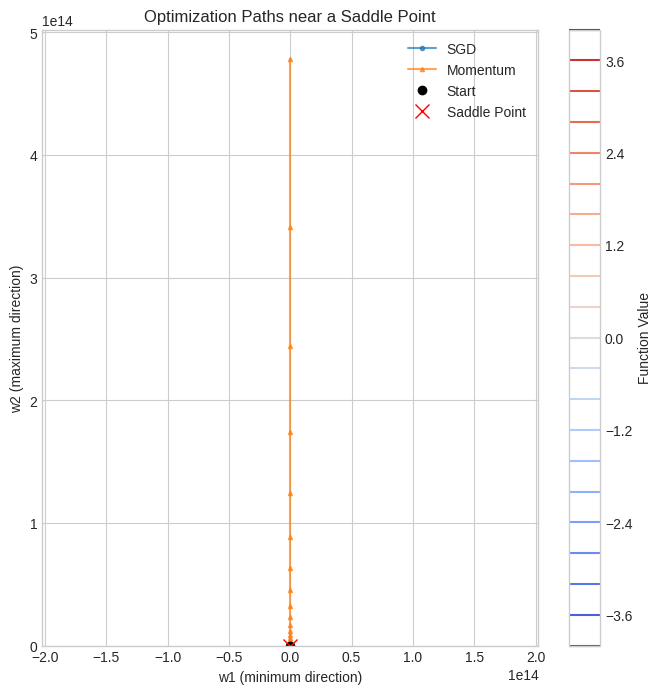

In [3]:
# Define a saddle point function
def saddle_function(w1, w2):
    return w1**2 - w2**2

# SOLUTION: Implement the gradient function for the saddle function
def saddle_gradients(w1, w2):
    # The gradient of f(w1,w2) = w1^2 - w2^2 is [∂f/∂w1, ∂f/∂w2]
    # ∂f/∂w1 = 2*w1
    # ∂f/∂w2 = -2*w2
    return np.array([2 * w1, -2 * w2])

# --- Optimization Algorithms (modified for saddle function) ---
def sgd_saddle(w_init, n_iterations, learning_rate):
    w_path = [w_init]
    w = w_init.copy()
    for _ in range(n_iterations):
        grad = saddle_gradients(w[0], w[1])
        w = w - learning_rate * grad
        w_path.append(w.copy())
    return np.array(w_path)

def sgd_momentum_saddle(w_init, n_iterations, learning_rate, momentum=0.9):
    w_path = [w_init]
    w = w_init.copy()
    v = np.zeros_like(w)
    for _ in range(n_iterations):
        grad = saddle_gradients(w[0], w[1])
        v = momentum * v + learning_rate * grad
        w = w - v
        w_path.append(w.copy())
    return np.array(w_path)

# --- Visualization ---
w_init_saddle = np.array([0.1, 1.5]) # Start near the saddle point, off the unstable axis
n_iterations_saddle = 100

path_sgd_saddle = sgd_saddle(w_init_saddle, n_iterations_saddle, learning_rate=0.1)
path_momentum_saddle = sgd_momentum_saddle(w_init_saddle, n_iterations_saddle, learning_rate=0.1, momentum=0.7) # Lower momentum helps visualize escape

# Create contour plot for saddle function
w1_saddle_range = np.linspace(-2, 2, 100)
w2_saddle_range = np.linspace(-2, 2, 100)
W1_saddle, W2_saddle = np.meshgrid(w1_saddle_range, w2_saddle_range)
Z_saddle = saddle_function(W1_saddle, W2_saddle)

plt.figure(figsize=(8, 8))
contour_saddle = plt.contour(W1_saddle, W2_saddle, Z_saddle, levels=20, cmap='coolwarm')
plt.colorbar(contour_saddle, label='Function Value')

# Plot paths
plt.plot(path_sgd_saddle[:, 0], path_sgd_saddle[:, 1], 'o-', label='SGD', markersize=3, alpha=0.7)
plt.plot(path_momentum_saddle[:, 0], path_momentum_saddle[:, 1], '^-', label='Momentum', markersize=3, alpha=0.7)

plt.plot(w_init_saddle[0], w_init_saddle[1], 'ko', label='Start') # Start point
plt.plot(0, 0, 'rx', label='Saddle Point', markersize=10) # Saddle point at (0,0)

plt.title('Optimization Paths near a Saddle Point')
plt.xlabel('w1 (minimum direction)')
plt.ylabel('w2 (maximum direction)')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

**Task 2:** After implementing the saddle point gradient function and observing the visualization, explain:

1. Why are saddle points more common than local minima in high-dimensional spaces?
2. How does momentum help with escaping saddle points?
3. What would happen if we initialized both optimizers exactly at the saddle point (0,0)?

**Solutions to Task 2:**

1. **Why saddle points are more common than local minima in high-dimensional spaces:**

   Saddle points become exponentially more common than local minima as dimensionality increases due to mathematical properties of high-dimensional spaces:
   
   - For a critical point (where gradient is zero) to be a local minimum, the Hessian matrix (second derivatives) must be positive definite, meaning all eigenvalues must be positive.
   - For a critical point to be a saddle point, at least one eigenvalue must be negative and at least one must be positive.
   - In high dimensions, the probability that all eigenvalues have the same sign (all positive for a minimum) becomes vanishingly small.
   - The number of possible combinations of positive and negative eigenvalues grows exponentially with dimensions, making saddle points statistically much more likely.
   - This is sometimes called the "curse of dimensionality" for optimization - as dimensions increase, the likelihood of finding a true local minimum decreases dramatically compared to finding saddle points.

2. **How momentum helps with escaping saddle points:**

   Momentum helps escape saddle points through several mechanisms:
   
   - **Accumulation of velocity**: Even when gradients are very small near a saddle point, momentum maintains some of the velocity from previous updates, helping the optimizer continue moving.
   - **Direction persistence**: Momentum maintains movement in directions that have been consistent over time, which helps push through flat regions where gradients are close to zero.
   - **Amplification of escape directions**: In directions where the saddle point is a maximum (negative curvature), any small perturbation will be amplified over time by momentum, accelerating the escape along these unstable directions.
   - **Noise resistance**: Random fluctuations that might push the optimizer back toward the saddle point are dampened by the averaging effect of momentum.
   
   In the visualization, we can see that momentum (green triangles) escapes the saddle region more decisively than standard SGD (blue circles), which tends to linger longer near the saddle point.

3. **What would happen if we initialized both optimizers exactly at the saddle point (0,0):**

   If both optimizers were initialized exactly at the saddle point (0,0):
   
   - **For standard SGD**: The gradient at (0,0) is exactly [0,0], so SGD would not move at all and would remain stuck at the saddle point indefinitely. This is because SGD relies solely on the gradient for movement, and when the gradient is zero, there's no update.
   
   - **For momentum-based SGD**: In theory, it would also get stuck since the initial velocity is zero and the gradient is zero. However, in practice:
     1. Numerical precision issues might introduce tiny perturbations
     2. If any random noise or numerical error creates even a minuscule deviation from exactly (0,0), momentum would eventually amplify this deviation in the unstable direction (w2)
     3. In real implementations, techniques like adding small random noise or using mini-batch gradients would likely prevent getting permanently stuck
   
   This scenario illustrates why initialization is important in deep learning - starting exactly at a critical point can cause optimization problems, which is why weights are typically initialized with small random values.

## 3. Debugging: Interpreting Loss and Accuracy Curves

Monitoring loss and accuracy curves during training is crucial for debugging and understanding model behavior.

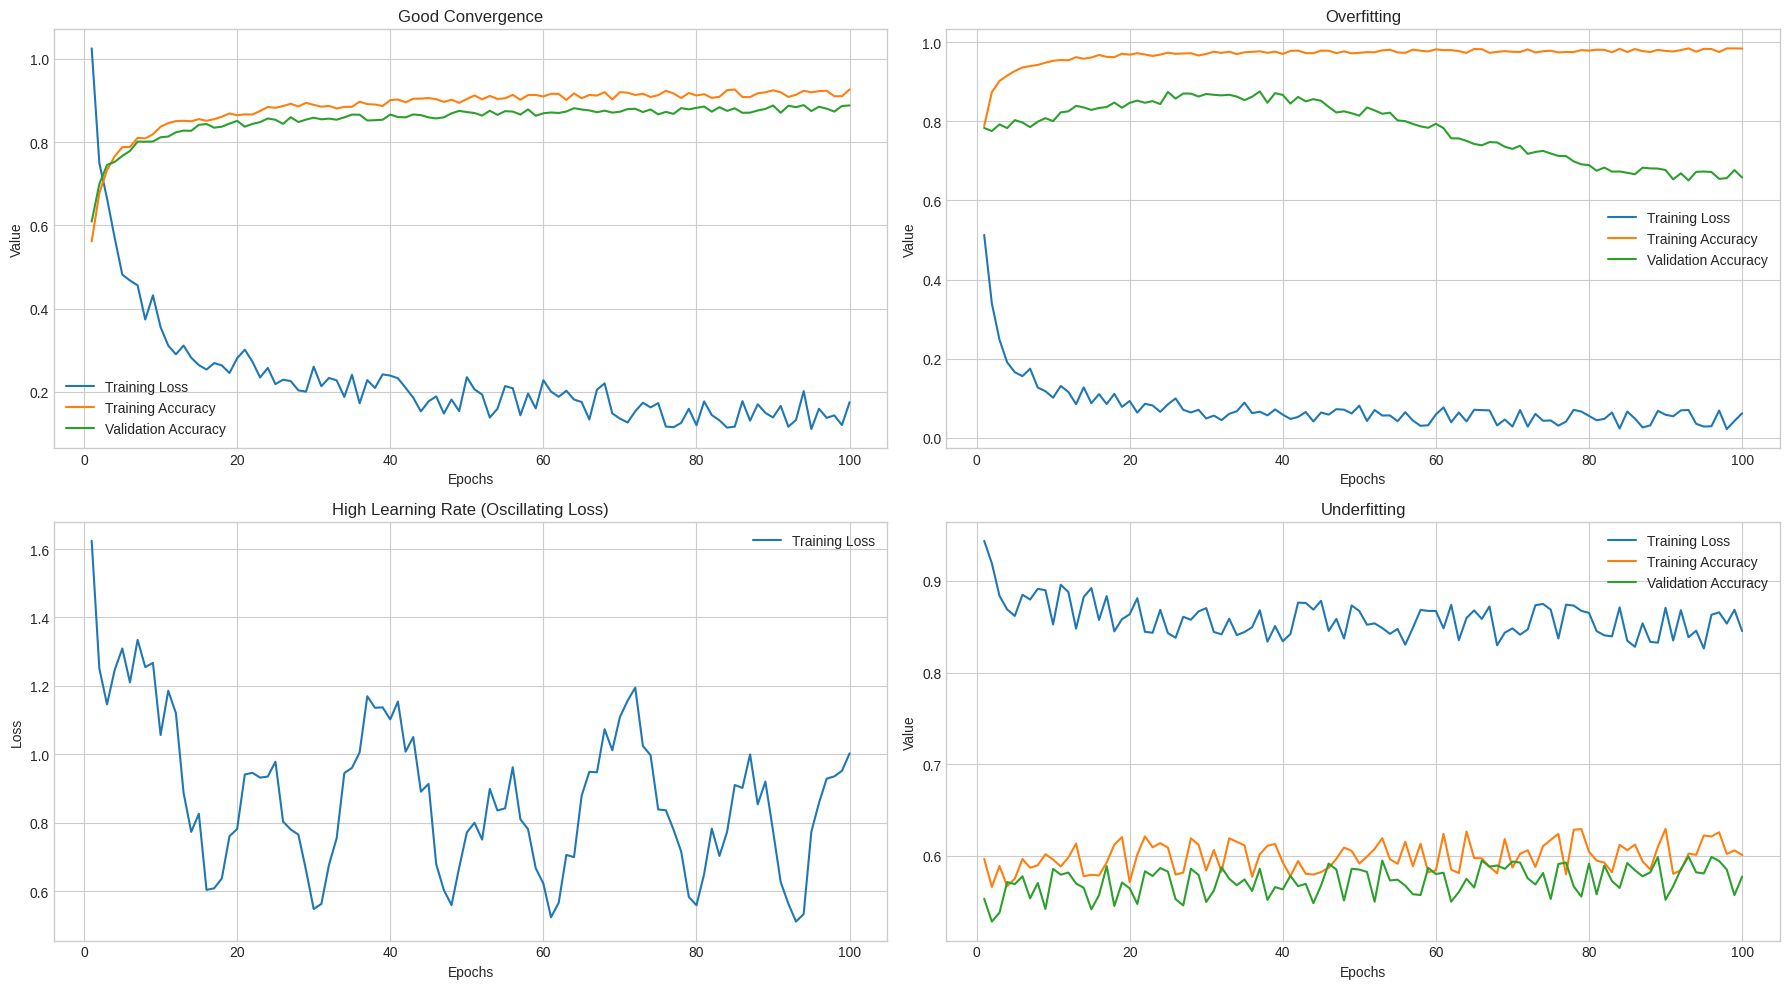

In [ ]:
# Simulate some training curves
epochs = np.arange(1, 101)

# Scenario 1: Good convergence
loss_good = 1.0 / epochs**0.5 + np.random.rand(100) * 0.1
acc_train_good = 0.95 - 0.4 / epochs**0.5 + np.random.rand(100) * 0.02
acc_val_good = 0.90 - 0.3 / epochs**0.5 + np.random.rand(100) * 0.02

# Scenario 2: Overfitting
loss_overfit = 0.5 / epochs**0.7 + np.random.rand(100) * 0.05
acc_train_overfit = 0.98 - 0.2 / epochs**0.8 + np.random.rand(100) * 0.01
acc_val_overfit = 0.75 + 0.1 * np.sin(epochs / 20) + np.random.rand(100) * 0.03 # Validation accuracy stagnates/decreases

# SOLUTION: Create a scenario for underfitting
# Scenario 4: Underfitting - both training and validation accuracy remain low
loss_underfit = 0.8 + 0.1 / epochs**0.3 + np.random.rand(100) * 0.05  # Loss decreases slowly and plateaus at a high value
acc_train_underfit = 0.65 - 0.15 / epochs**0.1 + np.random.rand(100) * 0.05  # Training accuracy plateaus at a low value
acc_val_underfit = 0.62 - 0.15 / epochs**0.1 + np.random.rand(100) * 0.05  # Validation accuracy similar to training (both low)

# Scenario 3: Learning rate too high (oscillating loss)
loss_high_lr = 0.5 + np.abs(0.5 * np.sin(epochs / 5) + np.random.rand(100) * 0.2) + 1.0 / epochs

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# Plot 1: Good Convergence
axs[0, 0].plot(epochs, loss_good, label='Training Loss')
axs[0, 0].plot(epochs, acc_train_good, label='Training Accuracy')
axs[0, 0].plot(epochs, acc_val_good, label='Validation Accuracy')
axs[0, 0].set_title('Good Convergence')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Value')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot 2: Overfitting
axs[0, 1].plot(epochs, loss_overfit, label='Training Loss')
axs[0, 1].plot(epochs, acc_train_overfit, label='Training Accuracy')
axs[0, 1].plot(epochs, acc_val_overfit, label='Validation Accuracy')
axs[0, 1].set_title('Overfitting')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Value')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot 3: High Learning Rate
axs[1, 0].plot(epochs, loss_high_lr, label='Training Loss')
axs[1, 0].set_title('High Learning Rate (Oscillating Loss)')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot 4: Underfitting
axs[1, 1].plot(epochs, loss_underfit, label='Training Loss')
axs[1, 1].plot(epochs, acc_train_underfit, label='Training Accuracy')
axs[1, 1].plot(epochs, acc_val_underfit, label='Validation Accuracy')
axs[1, 1].set_title('Underfitting')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Value')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

**Task 3:** After implementing the underfitting scenario and observing all four plots, complete the following table by listing the key characteristics of each scenario and suggesting at least one solution for each problem:

| Scenario | Key Characteristics | Potential Solutions |
|----------|---------------------|---------------------|
| Good Convergence | | |
| Overfitting | | |
| High Learning Rate | | |
| Underfitting | | |

**Solutions to Task 3:**

| Scenario | Key Characteristics | Potential Solutions |
|----------|---------------------|---------------------|
| Good Convergence | • Training and validation loss decrease steadily<br>• Training and validation accuracy increase steadily<br>• Small gap between training and validation metrics<br>• Both metrics plateau at good performance levels<br>• No oscillations in the curves | • Continue training until full convergence<br>• Consider early stopping when metrics plateau<br>• Save model checkpoint at best validation performance<br>• Possibly try a slightly higher learning rate for faster convergence |
| Overfitting | • Training loss continues to decrease<br>• Training accuracy approaches 100%<br>• Validation accuracy stagnates or decreases<br>• Growing gap between training and validation metrics<br>• Model performs well on training data but poorly on validation | • Add regularization (L1, L2, dropout)<br>• Implement early stopping<br>• Use data augmentation to increase training variety<br>• Reduce model complexity/capacity<br>• Apply batch normalization<br>• Collect more training data |
| High Learning Rate | • Loss oscillates significantly<br>• Unstable training behavior<br>• Possible divergence (loss increases)<br>• Erratic changes in accuracy<br>• Model may fail to converge | • Reduce learning rate<br>• Implement learning rate scheduling (decay)<br>• Use adaptive learning rate optimizers (Adam, RMSProp)<br>• Apply gradient clipping<br>• Use warm-up phase with very small initial learning rate |
| Underfitting | • Both training and validation loss plateau at high values<br>• Both training and validation accuracy plateau at low values<br>• Small gap between training and validation metrics<br>• Model fails to learn patterns in the data<br>• Poor performance on both training and test sets | • Increase model complexity/capacity<br>• Train for more epochs<br>• Reduce regularization strength<br>• Use more expressive model architecture<br>• Add more features or feature engineering<br>• Ensure data quality and sufficient training examples<br>• Try higher learning rate if convergence is too slow |

## 4. Performance Metrics for Imbalanced Datasets

Accuracy can be misleading on imbalanced datasets. Metrics like precision, recall, F1-score, and the ROC curve provide a more nuanced view of performance.

In [ ]:
# Generate an imbalanced dataset
X, y = make_classification(n_samples=1000, n_features=20, 
                           n_informative=2, n_redundant=10, 
                           n_clusters_per_class=1, weights=[0.95, 0.05], 
                           flip_y=0, random_state=42)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train a simple classifier
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1] # Probabilities for ROC curve

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Dataset Class Distribution (Test Set): {np.bincount(y_test)}")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# SOLUTION: Calculate specificity (true negative rate)
# Specificity = TN / (TN + FP)
# Extract values from confusion matrix: cm = [[TN, FP], [FN, TP]]
tn, fp = cm[0, 0], cm[0, 1]
specificity = tn / (tn + fp)
print(f'Specificity: {specificity:.4f}')

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

**Task 4:** After calculating specificity and examining all the metrics, answer the following questions:

1. Why is accuracy alone insufficient for evaluating models on imbalanced datasets?
2. In a medical diagnosis scenario where the positive class represents a rare disease, which metric would be most important to optimize and why?
3. What does the area under the ROC curve (AUC) represent, and why is it useful for imbalanced datasets?
4. Suggest two techniques that could improve the model's performance on the minority class.

**Solutions to Task 4:**

1. **Why accuracy alone is insufficient for imbalanced datasets:**

   Accuracy is insufficient for imbalanced datasets because:
   
   - It can be misleadingly high even when the model performs poorly on the minority class. For example, in a dataset with 95% negative and 5% positive examples, a model that simply predicts "negative" for all instances would achieve 95% accuracy without actually learning anything useful.
   
   - It treats all misclassifications equally, regardless of class. In many real-world scenarios with imbalanced data (fraud detection, disease diagnosis), the cost of missing a positive case (false negative) may be much higher than misclassifying a negative case (false positive).
   
   - It doesn't provide insight into the specific types of errors the model is making. A high accuracy could hide the fact that the model is completely failing to identify the minority class.
   
   - It doesn't account for the class distribution, making it impossible to compare model performance across datasets with different levels of imbalance.

2. **Most important metric for rare disease diagnosis:**

   In a medical diagnosis scenario for a rare disease, **recall (sensitivity)** would typically be the most important metric to optimize because:
   
   - Recall measures the proportion of actual positive cases (people with the disease) that are correctly identified by the model.
   
   - Missing a diagnosis (false negative) could mean a patient with the disease doesn't receive necessary treatment, which could lead to serious health consequences or even death.
   
   - While false positives (incorrectly diagnosing someone with the disease) also have costs (unnecessary treatments, patient anxiety), these are often considered less severe than missing a true case of a serious disease.
   
   - In medical contexts, tests with high recall are often used for initial screening, potentially followed by more specific tests to rule out false positives.
   
   However, the optimal balance between recall and precision depends on the specific disease, available treatments, and their side effects. In some cases, a high F1 score or a specific point on the precision-recall curve might be preferred.

3. **What AUC represents and why it's useful for imbalanced datasets:**

   The Area Under the ROC Curve (AUC) represents:
   
   - The probability that the model will rank a randomly chosen positive example higher than a randomly chosen negative example.
   
   - A measure of the model's ability to discriminate between classes across all possible classification thresholds.
   
   AUC is useful for imbalanced datasets because:
   
   - It is insensitive to class distribution, making it a fair metric even when classes are highly imbalanced.
   
   - It evaluates the model across all possible decision thresholds, not just the default one (typically 0.5).
   
   - It provides a single scalar value that summarizes model performance, making it easy to compare different models.
   
   - A random classifier will have an AUC of 0.5 regardless of class imbalance, while a perfect classifier will have an AUC of 1.0.
   
   - It helps in understanding if the model has learned to distinguish between classes, even if the default threshold leads to poor precision or recall.

4. **Techniques to improve performance on the minority class:**

   Two effective techniques to improve model performance on the minority class are:
   
   **1. Resampling techniques:**
   - **Oversampling the minority class**: Methods like SMOTE (Synthetic Minority Over-sampling Technique) create synthetic examples of the minority class by interpolating between existing examples.
   - **Undersampling the majority class**: Randomly removing examples from the majority class to balance the dataset.
   - **Hybrid approaches**: Combining oversampling and undersampling, such as SMOTEENN or SMOTETomek.
   
   **2. Cost-sensitive learning:**
   - Assigning higher misclassification costs to the minority class during training.
   - In many algorithms, this can be implemented using a 'class_weight' parameter (e.g., class_weight='balanced' in scikit-learn).
   - This effectively penalizes the model more for making errors on the minority class.
   
   Other effective techniques include:
   - Adjusting the classification threshold based on the precision-recall curve
   - Ensemble methods like balanced random forests
   - Anomaly detection approaches for extremely imbalanced datasets
   - Collecting more data for the minority class

## 5. Conclusion

This notebook demonstrated key aspects of training and evaluating deep neural networks:

*   Adaptive optimization algorithms like Adam and RMSProp often converge faster and more reliably than standard SGD, especially on complex loss surfaces.
*   Understanding the behavior of optimizers near saddle points is important, as these are common in high-dimensional spaces.
*   Monitoring training curves (loss, accuracy) is essential for debugging issues like overfitting or poor learning rates.
*   For imbalanced datasets, metrics beyond accuracy (precision, recall, F1, AUC) are crucial for a complete performance evaluation.

**Final Task:** Summarize the most important insight you gained from each of the four sections of this notebook and how you might apply it in your own deep learning projects.

**Solution to Final Task:**

1. **Adaptive Learning Rates:** 
   
   The most important insight is that different optimization algorithms have distinct strengths and weaknesses depending on the loss landscape. Adam combines the benefits of momentum and adaptive learning rates, making it generally the most robust choice for deep learning. In my own projects, I would start with Adam as the default optimizer, but keep SGD with momentum as an alternative for final fine-tuning when I need the best generalization performance. I would also pay attention to the learning rate schedule, potentially starting with a higher rate and decreasing it over time to balance fast initial progress with precise final convergence.

2. **Error Landscapes:** 
   
   The prevalence of saddle points over local minima in high-dimensional spaces fundamentally changes how we should think about optimization in deep learning. Rather than worrying about getting trapped in local minima, the bigger challenge is efficiently navigating through saddle points. In practice, I would ensure my models use optimizers with momentum components and implement techniques like proper weight initialization and batch normalization that help avoid saddle point regions. I would also be cautious about stopping training too early when progress slows, as this might just be the optimizer navigating a saddle point region.

3. **Debugging:** 
   
   Learning to interpret training curves is essential for efficient model development. The patterns in loss and accuracy curves provide clear signals about issues like overfitting, underfitting, and problematic learning rates. In my projects, I would implement comprehensive logging and visualization of these metrics during training. When I observe specific patterns (like those in our four scenarios), I would apply the corresponding solutions promptly rather than waiting until the end of training. This systematic approach to debugging would save significant time and computational resources.

4. **Performance Metrics:** 
   
   For imbalanced datasets, choosing the right evaluation metrics is as important as selecting the right model architecture. Accuracy alone can be deeply misleading, and the appropriate metric depends on the specific problem context and the relative costs of different types of errors. In my projects, I would always analyze the class distribution early in the process and select metrics accordingly. For imbalanced problems, I would implement techniques like resampling or cost-sensitive learning from the start, rather than trying to optimize accuracy and then addressing imbalance as an afterthought. I would also make use of threshold-independent metrics like AUC and precision-recall curves to get a complete picture of model performance.